# Numeric Simulation of the g2 for a single emitter


In [1]:
import seaborn as sns
import pandas as pd 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d


def emit_photons(n_pulses=100000, lifetime=1):
    
    time_bins = np.arange(0,12.5*n_pulses,12.5)

    photons = np.random.exponential(scale=lifetime, size=n_pulses)
    timestamps = photons + time_bins
    
    return timestamps
    
    
def hbt_histogram_from_time(lifetime=1):

    timestamps = emit_photons(lifetime=lifetime)
    
    timestamps = loss_function(timestamps, 0.25)

    # Simulate splitting (randomly)
    beam_splitter = np.random.binomial(1, 0.5, size=timestamps.size).astype(bool)
    a = timestamps[beam_splitter]
    b = timestamps[~beam_splitter]

    A = np.ones([a.size,2])
    A[:,0] = a
    ch1 = pd.DataFrame(A, columns=['times', 'id'])

    B = np.zeros([b.size,2])
    B[:,0] = b
    ch2 = pd.DataFrame(B, columns=['times', 'id'])

    diff = pd.concat([ch1,ch2]).sort_values('times').diff().dropna()
    diff = diff[~(diff['id']==0)]
    differences = diff['times'].multiply(diff['id'])    
    
    return differences


def loss_function(timestamps, transmission):
    
    # Simulate optical loss
    transmitted = np.random.binomial(1, transmission, size=timestamps.size).astype(bool)
    surviving_photons = timestamps[transmitted]
    
    return surviving_photons

def normalized_g2(lifetime, bw=None):
    
    x_norm = np.linspace(-60,60,120)

    diffs = hbt_histogram_from_time(lifetime=lifetime)
    
    fig, ax = plt.subplots(1)
    sns.kdeplot(diffs, shade=True, ax=ax, bw=bw)

    # Extract y values
    y = ax.get_lines()[0].get_ydata()
    y = y/y.max()
    x = ax.get_lines()[0].get_xdata()

    y_norm = np.interp(x_norm, x, y)
        
    output = pd.Series(data=y_norm, index=x_norm, name=lifetime).to_frame()
    plt.close("all")
    
    return output


def find_best_tau(lifetimes, target_g20=0.5, bw=None):
    
    simulated_g20 = np.zeros(len(lifetimes))
        
    for i, lt in enumerate(lifetimes):

        g2 = normalized_g2(lt, bw=bw)
        g2.reset_index(inplace=True)
        simulated_g20[i] = g2.iloc[(g2['index'] - 0).abs().argsort()[0],1]
        
    # Find tau resulting in a g2o
    idx = np.abs(simulated_g20 - target_g20).argmin()
    
    closest_g2 = simulated_g20[idx]
    closest_lifetime = lifetimes[idx]
    
    return closest_lifetime 

## The time of a photon-emisison follows a negative exponential curve


Text(0.5,1,'Time Series of the emitted photons')

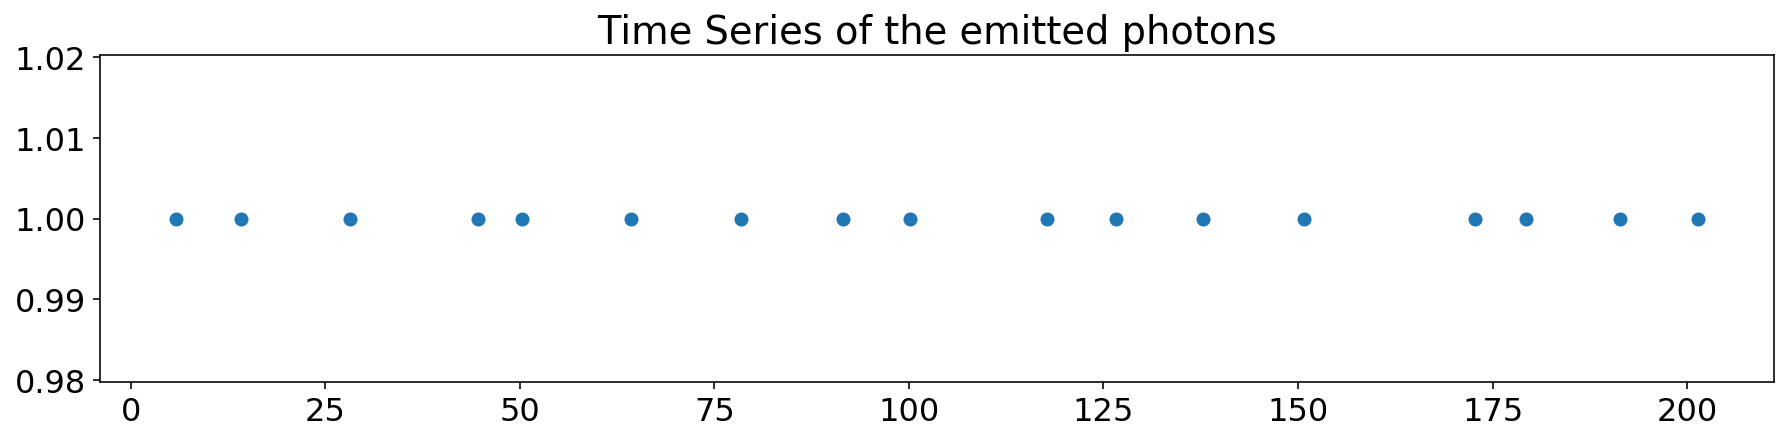

In [2]:
lifetime=2

delayRange = 200
numPulses = int(np.floor(delayRange/12.5)+1)
pulses = np.linspace(0,200, numPulses)

photons = np.random.exponential(scale=lifetime, size=numPulses)
timestamps = np.around(photons,2) + np.around(pulses,2) 

# timestamps
fig, ax = plt.subplots(1, figsize=[15,3])
_ = ax.scatter(timestamps, np.ones(photons.shape[0]))
ax.set_title("Time Series of the emitted photons")


## Find the best lifetime given an observed value of the g2 in tau=0


6.2105263157894735

            6.210526
-60.000000  0.378827
-58.991597  0.390427
-57.983193  0.402027
-56.974790  0.413627
-55.966387  0.425228
-54.957983  0.436828
-53.949580  0.447754
-52.941176  0.451763
-51.932773  0.455771
-50.924370  0.459780
-49.915966  0.463788
-48.907563  0.467796
-47.899160  0.471805
-46.890756  0.475813
-45.882353  0.504630
-44.873950  0.536780
-43.865546  0.568931
-42.857143  0.601081
-41.848739  0.633232
-40.840336  0.665382
-39.831933  0.697533
-38.823529  0.693543
-37.815126  0.672096
-36.806723  0.650649
-35.798319  0.629202
-34.789916  0.607755
-33.781513  0.586308
-32.773109  0.564861
-31.764706  0.578433
-30.756303  0.631967
...              ...
 30.756303  0.716637
 31.764706  0.684286
 32.773109  0.651934
 33.781513  0.633465
 34.789916  0.624182
 35.798319  0.614899
 36.806723  0.605617
 37.815126  0.596334
 38.823529  0.587051
 39.831933  0.577768
 40.840336  0.569566
 41.848739  0.563020
 42.857143  0.556475
 43.865546  0.549930
 44.873950  0.543385
 45.882353  0

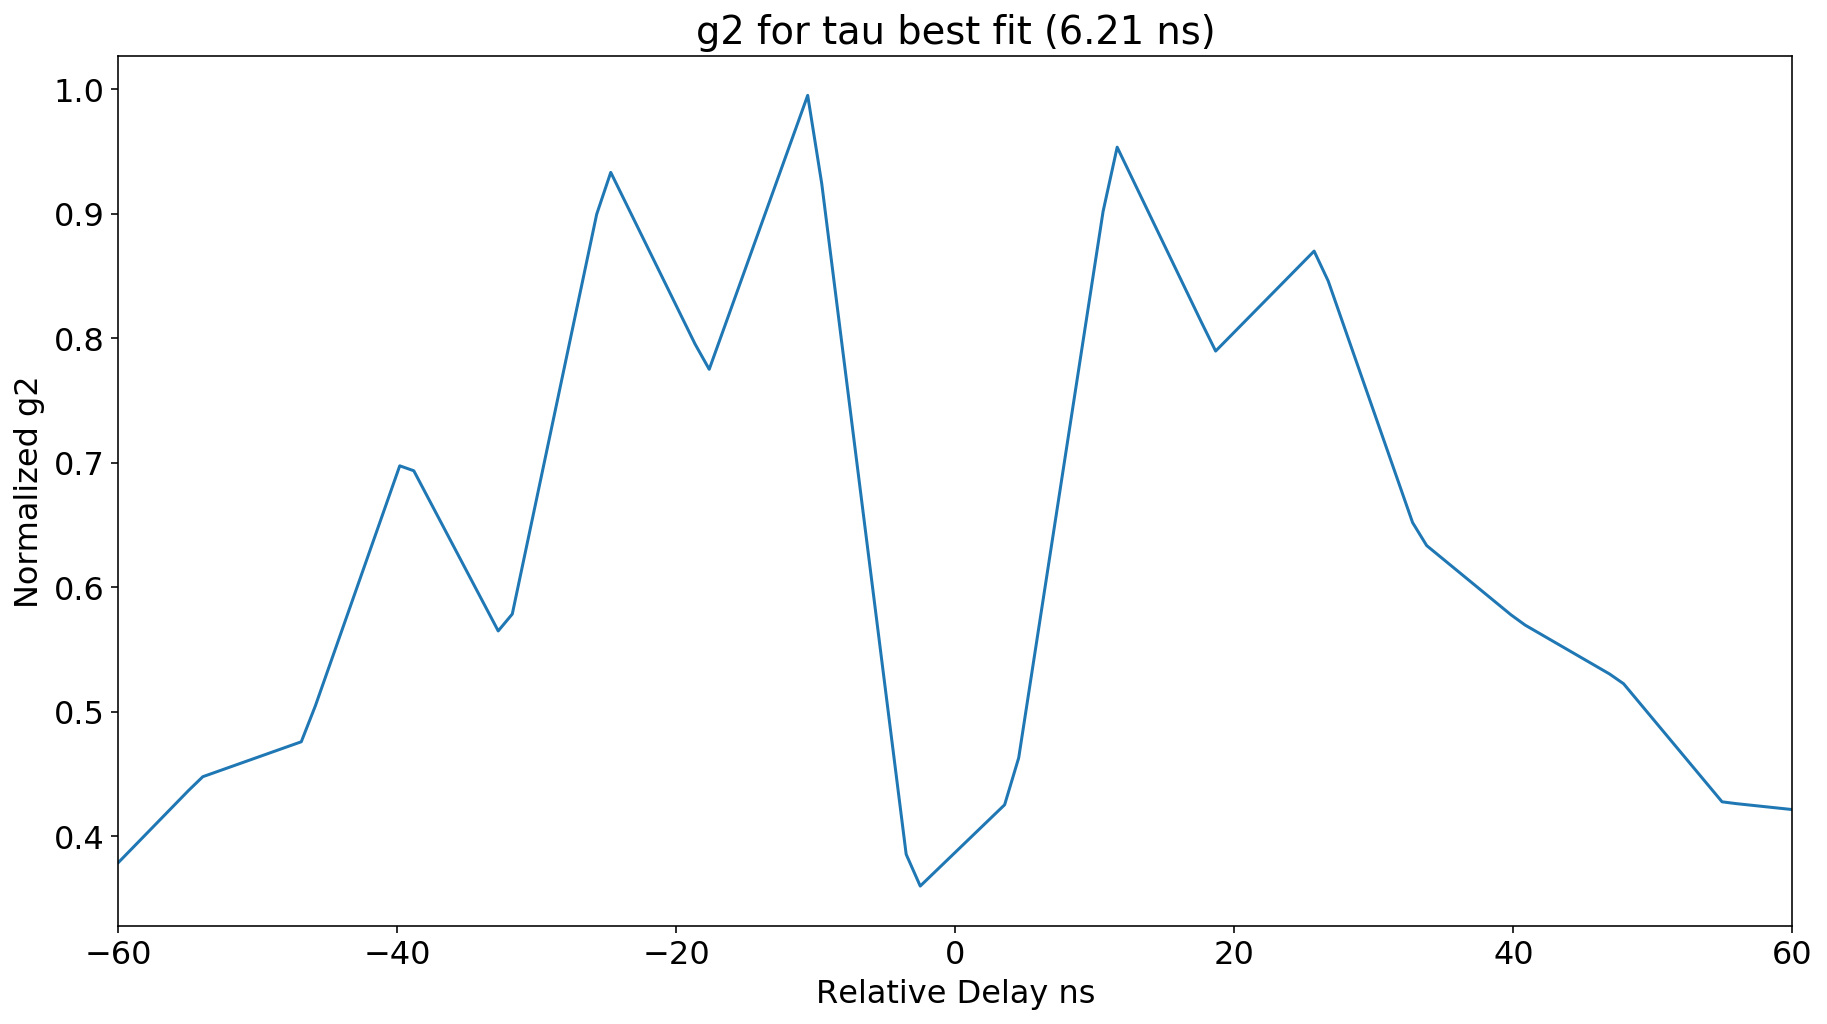

In [3]:
lifetimes = np.linspace(1, 10, 20)
best_lifetime = find_best_tau(lifetimes, target_g20=0.4, bw=1)
best_lifetime

g2 = normalized_g2(best_lifetime, bw=1)

fig, ax = plt.subplots(1, figsize=[15,8])
g2.plot(ax=ax, legend=False)

_ = ax.set_title(f"g2 for tau best fit ({np.around(best_lifetime, 2)} ns)")
_ = ax.set_xlabel("Relative Delay ns")
_ = ax.set_ylabel("Normalized g2")

print(g2)

## See how the g2 would change as a function of lifetime


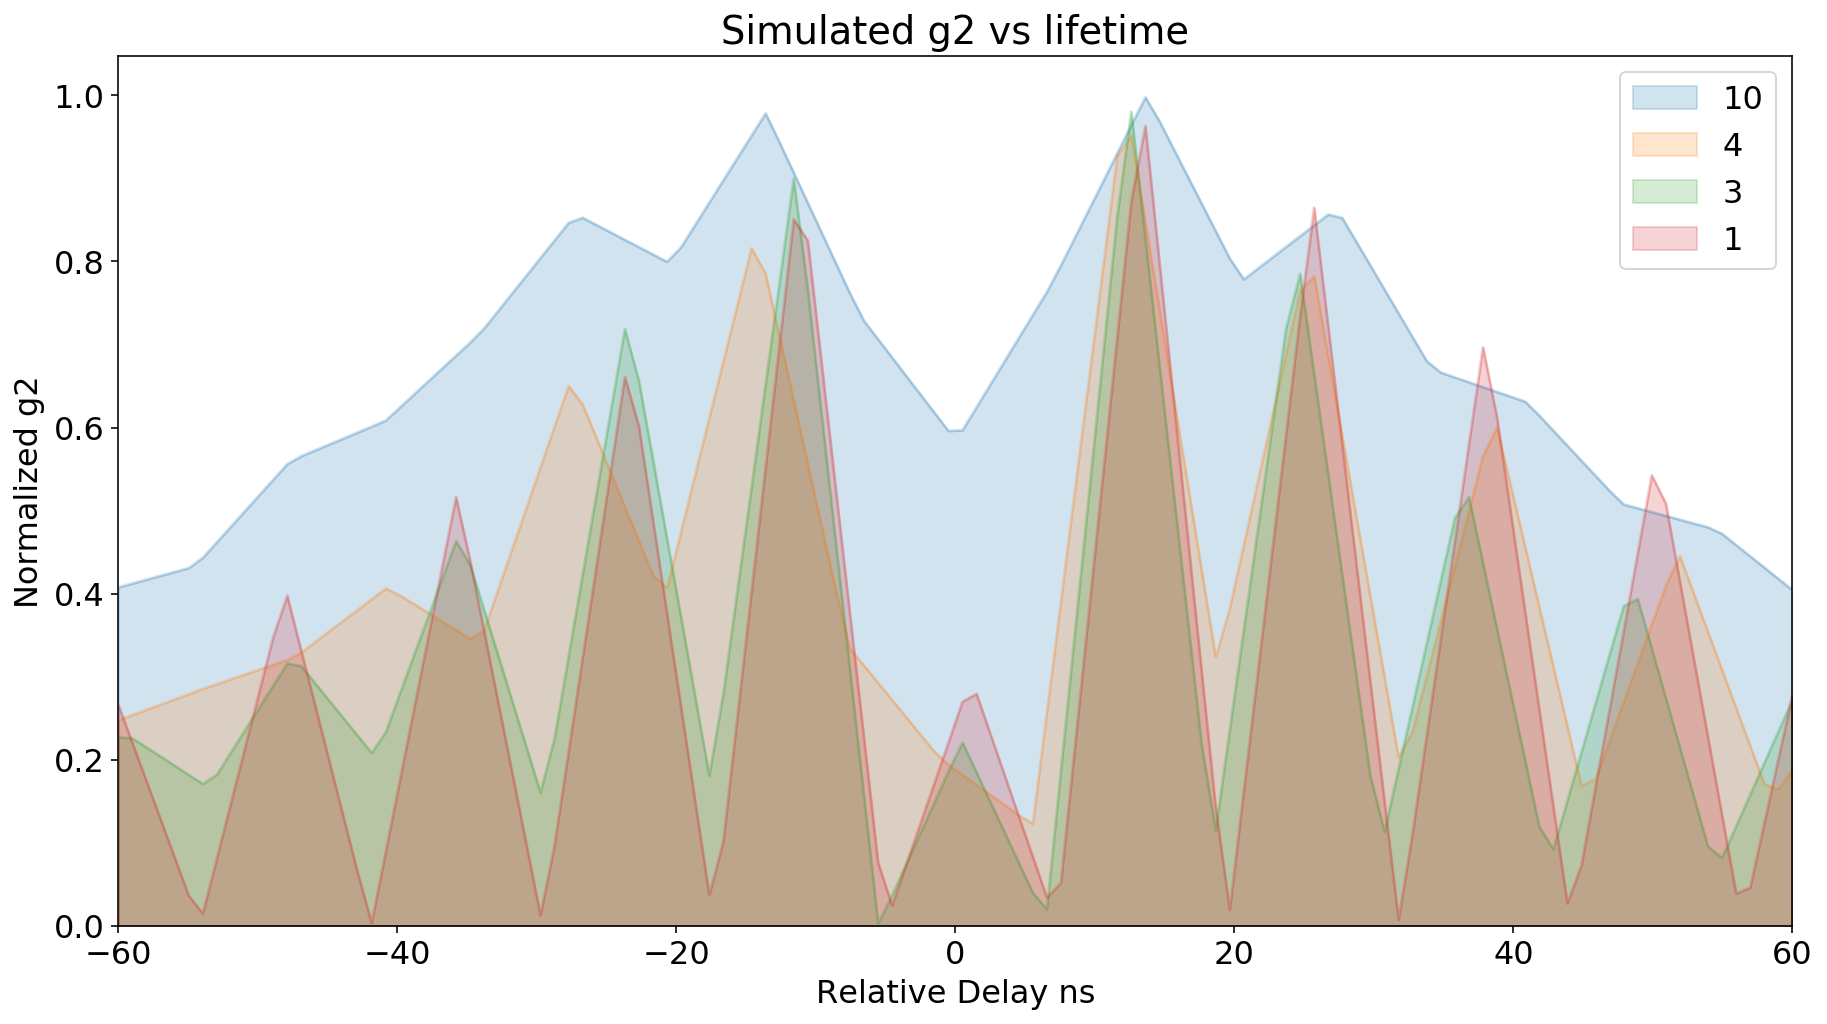

In [4]:
df_list = []
for i, lt in enumerate([1, 3, 4, 10]):
    
    g2 = normalized_g2(lt, bw=1)
    df_list.append(g2)
                 
out = pd.concat(df_list, axis=1)


fig, ax = plt.subplots(1,  figsize=[15,8])
out[[10, 4, 3, 1]].plot.area(alpha=0.2, ax=ax, stacked=False)
_ = ax.set_title(f"Simulated g2 vs lifetime")
_ = ax.set_xlabel("Relative Delay ns")
_ = ax.set_ylabel("Normalized g2")


## Compare to Experimental g2 curve (1000nm)

-69.5


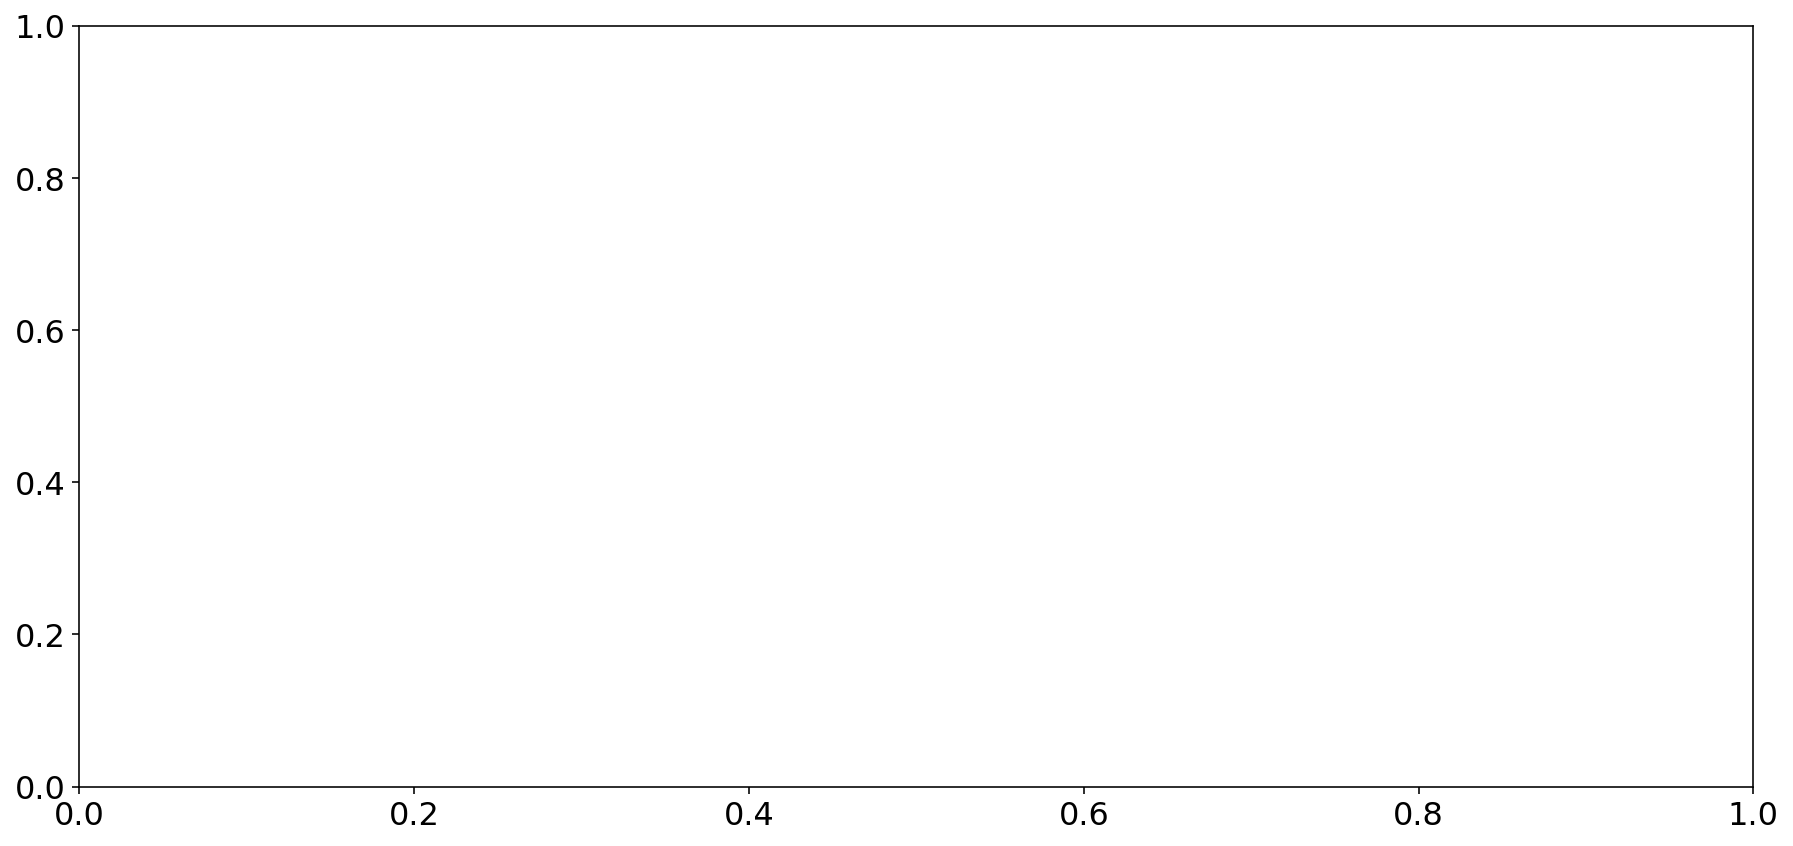

In [5]:
#import experimental data
exp_g2_1000 = np.genfromtxt ('g2_1000nm_exp.csv', delimiter=",")

print(exp_g2_1000[0,1])

fig, ax = plt.subplots(1, figsize=[15,7])
#ax.plot(ax=ax, legend=False)

#_ = ax.set_title(f"Experimental g2 for 1000nm emitter)")
#_ = ax.set_xlabel("Relative Delay ns")
#_ = ax.set_ylabel("g2")